In [4]:
import pandas as pd
from scipy.stats import iqr
from src.main.rl.evaluation.phase_3_evaluation import create_evaluation_df_phase3

paths=[
"src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_None_RewardOption2Wrapper_TD3_training_04_06",
"src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06",
"src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06",


"src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_SAC_training_04_06",
"src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_PPO_training_04_06",
"src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_A2C_training_04_06",
]
path_to_save="src/main/rl/evaluation/output/phase3_evaluation_results.csv"
pd.options.display.max_colwidth = 300
df = pd.DataFrame()
try:
    df = pd.read_csv("src/main/rl/evaluation/output/phase3_evaluation_results.csv")
except:
    pass

if df.empty:
    df = create_evaluation_df_phase3(path_to_save,paths)


In [9]:
# Statistics over the whole dataframe
df_total1=df.drop(columns=["full_path","combination", "scenario", "alg", "action_wrapper", "obs_wrapper", "automation_wrapper"]).agg(["mean","max","min", "std"])
df_total2=df.drop(columns=["full_path","combination", "scenario", "alg", "action_wrapper", "obs_wrapper", "automation_wrapper"]).groupby(lambda x: True,dropna=True).agg([iqr])
df_total2.columns=df_total2.columns.get_level_values(0)
df_total2["index"]="iqr"
df_total=df_total1.reset_index().merge(df_total2, how="outer").set_index("index")

C:\Users\Niklas\AppData\Local\Temp\ipykernel_6028\1495946047.py:3: FutureWarning: ['condensator_pump_blown', 'water_pump_blown', 'episode_length_1000_condensator_pump_blown', 'episode_length_1000_water_pump_blown'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_total2=df.drop(columns=["full_path","combination", "scenario", "alg", "action_wrapper", "obs_wrapper", "automation_wrapper"]).groupby(lambda x: True,dropna=True).agg([iqr])


In [4]:
# EXP1: Criticality Score across all 60 models
print(df_total[["criticality_score"]].to_latex())

\begin{tabular}{lr}
\toprule
{} &  criticality\_score \\
index &                    \\
\midrule
mean  &         208.444868 \\
max   &         237.439009 \\
min   &         172.821218 \\
std   &          19.153601 \\
iqr   &          35.776644 \\
\bottomrule
\end{tabular}



C:\Users\Niklas\AppData\Local\Temp\ipykernel_3996\2461436129.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_total[["criticality_score"]].to_latex())


In [12]:
# Statistics per combination
df_statistics_per_combination = (
    df.drop(columns=["full_path"]).groupby(
        ["combination", "scenario", "alg", "action_wrapper", "obs_wrapper", "automation_wrapper"], dropna=False)
        .agg(["mean","max","min", "std", iqr])
)
# Necessary to set index as alphabetical is confusing for the thesis 
df_statistics_per_combination["index"]=([0,1,3,2,5,4])
df_statistics_per_combination=df_statistics_per_combination.reset_index().set_index(["index","combination"]).sort_index()
df_statistics_per_combination.columns = ["_".join(a) for a in df_statistics_per_combination.columns.to_flat_index()]
save_df_per_combination=df_statistics_per_combination.copy()
df_statistics_per_combination

C:\Users\Niklas\AppData\Local\Temp\ipykernel_6028\2027214207.py:3: FutureWarning: ['condensator_pump_blown', 'water_pump_blown', 'episode_length_1000_condensator_pump_blown', 'episode_length_1000_water_pump_blown'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.drop(columns=["full_path"]).groupby(


,,scenario_,alg_,action_wrapper_,obs_wrapper_,automation_wrapper_,Unnamed: 0_mean,Unnamed: 0_max,Unnamed: 0_min,Unnamed: 0_std,Unnamed: 0_iqr,...,create_starting_state_option3b_criticality_mean,create_starting_state_option3b_criticality_max,create_starting_state_option3b_criticality_min,create_starting_state_option3b_criticality_std,create_starting_state_option3b_criticality_iqr,create_starting_state_option3b_timesteps_mean,create_starting_state_option3b_timesteps_max,create_starting_state_option3b_timesteps_min,create_starting_state_option3b_timesteps_std,create_starting_state_option3b_timesteps_iqr
index,combination,,,,,,,,,,,,,,,,,,,,,
0,src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_None_RewardOption2Wrapper_TD3_training_04_06,src.main.rl.envs.scenario1:Scenario1,<class 'stable_baselines3.td3.td3.TD3'>,ActionSpaceOption3Wrapper,ObservationOption4Wrapper,NaN,4.5,9,0,3.02765,4.5,...,114.512014,210.872382,0.423077,81.959851,131.365147,152.7,250,1,105.075687,174.5
1,src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_SAC_training_04_06,src.main.rl.envs.scenario1:Scenario1,<class 'stable_baselines3.sac.sac.SAC'>,ActionSpaceOption3Wrapper,ObservationOption5Wrapper,NPPAutomationWrapper,34.5,39,30,3.02765,4.5,...,201.607988,208.531125,189.226198,5.686540,6.448305,250.0,250,250,0.000000,0.0
2,src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06,src.main.rl.envs.scenario2:Scenario2,<class 'stable_baselines3.ppo.ppo.PPO'>,ActionSpaceOption3Wrapper,ObservationOption5Wrapper,NaN,14.5,19,10,3.02765,4.5,...,194.470170,205.271397,183.243743,6.190727,6.274119,250.0,250,250,0.000000,0.0
3,src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_PPO_training_04_06,src.main.rl.envs.scenario2:Scenario2,<class 'stable_baselines3.ppo.ppo.PPO'>,ActionSpaceOption3Wrapper,ObservationOption4Wrapper,NPPAutomationWrapper,44.5,49,40,3.02765,4.5,...,185.403751,202.408051,167.645829,10.336876,14.324139,250.0,250,250,0.000000,0.0
4,src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06,src.main.rl.envs.scenario3:Scenario3,<class 'stable_baselines3.ppo.ppo.PPO'>,ActionSpaceOption3Wrapper,ObservationOption5Wrapper,NaN,24.5,29,20,3.02765,4.5,...,194.930599,213.131235,107.229758,31.267522,9.608887,239.1,250,141,34.468826,0.0
5,src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_A2C_training_04_06,src.main.rl.envs.scenario3:Scenario3,<class 'stable_baselines3.a2c.a2c.A2C'>,ActionSpaceOption3Wrapper,ObservationOption5Wrapper,NPPAutomationWrapper,54.5,59,50,3.02765,4.5,...,168.591506,206.381286,136.420702,23.875622,31.758746,229.0,250,179,28.205594,43.0


In [13]:
# EXP1: Criticality Score per combination
print(df_statistics_per_combination[["criticality_score_mean"]].round(2))
print(df_statistics_per_combination[["criticality_score_mean","criticality_score_max","criticality_score_min","criticality_score_std","criticality_score_iqr"]].droplevel(1).transpose().round(2).to_latex())


                                                                                                                                                                              criticality_score_mean
index combination                                                                                                                                                                                   
0     src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_None_RewardOption2Wrapper_TD3_training_04_06                                  192.26
1     src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_SAC_training_04_06                  190.93
2     src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06                                  220.51
3     src/main/

C:\Users\Niklas\AppData\Local\Temp\ipykernel_6028\3201395392.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_statistics_per_combination[["criticality_score_mean","criticality_score_max","criticality_score_min","criticality_score_std","criticality_score_iqr"]].droplevel(1).transpose().round(2).to_latex())


In [7]:
import pandas as pd
from src.main.rl.utils.parser import parse_wrapper
from src.main.rl.utils.combined_parser import parse_information_from_path
from src.main.rl.evaluation.eval import evaluate

paths_best_models = [
    "src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_None_RewardOption2Wrapper_TD3_training_04_06",
    "src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_SAC_training_04_06",
    
    "src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06",
    "src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_PPO_training_04_06",
    
    "src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06",
    "src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_A2C_training_04_06",
]
# Choose one Combiniation:

def prepare_one_combiniation_actions_and_obs_for_analysis(path_to_model:str,episode_length:int=250,number_of_models:int=10):
    # This function transforms the actions and observations for all ten models per combination so that we can easily aggregated per timestep and create
    # the corresponding statistics per timestamp and not only over the whole evaluation.
    # It returns a list of 5 dataframes. Each for one dimension of the action space. In the dataframe we have 250 rows (one per timestamp)
    # and 10 columns with the different models/runs. so if we aggregate of the columns we get the statistics for a action dimession over the 250 episodes (rows).
    # Same with different number of df for obs.
    # Also returns just a list were all actions taken and obs taken are appended.
    result_list_actions=[pd.DataFrame() for i in range(5)]
    result_list_obs=[pd.DataFrame() for i in range(6)]
    
    list_of_all_actions_taken=[]
    list_of_all_obs_taken=[]
    
    for number in range(1,number_of_models+1): # change to range(1,10) to not have model 10 in this. Which seems to be an otuliers model for combination 1.
        result_dict = {}
        full_path = path_to_model + f"_{number}"
        path_to_overhand = full_path + "/best_model.zip"
            
        action_wrapper, automation_wrapper, obs_wrapper, reward_wrapper = parse_wrapper(full_path)
        scenario, alg, wrapper_maker = parse_information_from_path(full_path)
        # Switch episode length here
        cum_reward, criticality_score, total_timesteps, actions_taken, obs_taken,info = evaluate(scenario, path_to_overhand, alg, wrapper_maker, episode_length=episode_length)
        # actions taken is a list of lists. The first list contains 250 further list (one per timestep). The inner list contaijs 5 values (one per dimension in the action space)
        list_of_all_actions_taken.append(actions_taken)
        list_of_all_obs_taken.append(obs_taken)
        intermediate_df_actions=pd.DataFrame(actions_taken)
        intermediate_df_obs=pd.DataFrame(obs_taken)
        result_list_actions[0]=result_list_actions[0].join(intermediate_df_actions[0].rename(f"action_0_run_{number}").to_frame(), how="outer")
        result_list_actions[1]=result_list_actions[1].join(intermediate_df_actions[1].rename(f"action_1_run_{number}").to_frame(), how="outer")
        result_list_actions[2]=result_list_actions[2].join(intermediate_df_actions[2].rename(f"action_2_run_{number}").to_frame(), how="outer")
        result_list_actions[3]=result_list_actions[3].join(intermediate_df_actions[3].rename(f"action_3_run_{number}").to_frame(), how="outer")
        result_list_actions[4]=result_list_actions[4].join(intermediate_df_actions[4].rename(f"action_4_run_{number}").to_frame(), how="outer")
        
        result_list_obs[0]=result_list_obs[0].join(intermediate_df_obs[0].rename(f"action_0_run_{number}").to_frame(), how="outer")
        result_list_obs[1]=result_list_obs[1].join(intermediate_df_obs[1].rename(f"action_1_run_{number}").to_frame(), how="outer")
        result_list_obs[2]=result_list_obs[2].join(intermediate_df_obs[2].rename(f"action_2_run_{number}").to_frame(), how="outer")
        result_list_obs[3]=result_list_obs[3].join(intermediate_df_obs[3].rename(f"action_3_run_{number}").to_frame(), how="outer")
        result_list_obs[4]=result_list_obs[4].join(intermediate_df_obs[4].rename(f"action_4_run_{number}").to_frame(), how="outer")
        result_list_obs[5]=result_list_obs[5].join(intermediate_df_obs[5].rename(f"action_5_run_{number}").to_frame(), how="outer")
    return result_list_actions, result_list_obs,list_of_all_actions_taken,list_of_all_obs_taken

path=paths_best_models[0]
actions_prepared, obs_prepared,list_of_all_actions_taken,list_of_all_obs_taken=prepare_one_combiniation_actions_and_obs_for_analysis(path)


Criticality Score1: 178.38030941725677
[209.79135]
Criticality Score1: 186.1900657985489
[232.37787]
Criticality Score1: 202.16097834231303
[229.64128]
Criticality Score1: 200.24862108060037
[227.66989]
Criticality Score1: 187.58651717021755
[237.15456]
Criticality Score1: 185.2213432346947
[236.47679]
Criticality Score1: 225.07165066580052
[219.37975]
Criticality Score1: 196.6687259423687
[235.30109]
Criticality Score1: 186.11584603330698
[232.75609]
Criticality Score1: 174.96693963004714
[219.77281]


In [8]:
# Actions Analysis Combi 1
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
scaling_factors_scenario_1 = [100, 2000, 1, 1, 2000]
color_mapping = {
    "standard": "#1D2D5F",
    "red":"#F65E5D",
    "orange": "#FF8800",
}
for idx,item in enumerate(actions_prepared):
    item=item.applymap(lambda x: int(round((x + 1) * (scaling_factors_scenario_1[idx] / 2))))
    actions_prepared[idx]=item.agg(["mean","min","max","std"],axis=1)
    actions_prepared[idx]["minus"]=actions_prepared[idx]["mean"]-actions_prepared[idx]["std"]
    actions_prepared[idx]["plus"]=actions_prepared[idx]["mean"]+actions_prepared[idx]["std"]

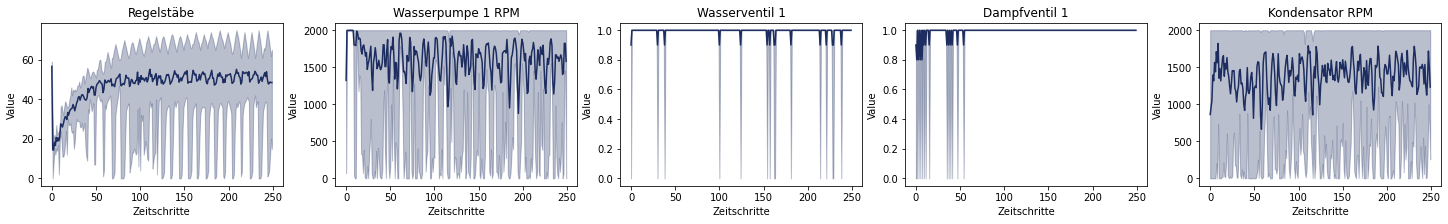

In [9]:
# Actions Analysis Combi 1
from src.main.rl.utils.constants import (
    scaling_factors_scenario_1,
    action_dimensions_german)
fig, ax = plt.subplots(1, 5,constrained_layout=True)
fig.set_figheight(3) 
fig.set_figwidth(20) 
[ax[idx].plot(item["mean"],color=color_mapping["standard"]) for idx, item in enumerate(actions_prepared)]
#[ax[idx].fill_between([i for i in range(250)],item["plus"],item["minus"],color=color_mapping["standard"],alpha=0.3) for idx, item in enumerate(result_list)]
[ax[idx].fill_between([i for i in range(250)],item["min"],item["max"],color=color_mapping["standard"],alpha=0.3) for idx, item in enumerate(actions_prepared)]
[ax[idx].set_xlabel("Zeitschritte") for idx in range(5)]
[ax[idx].set_ylabel("Value") for idx in range(5)]
[ax[idx].set_title(action_dimensions_german[idx]) for idx in range(5)]

#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_actions_plot_with_min_max_scen1_w.png",
#    format="png",
#    dpi=300,
#)
plt.show()

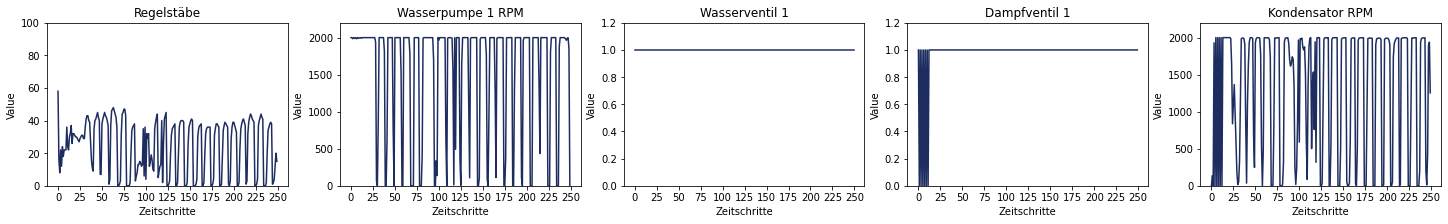

In [10]:
# Action: Modell 10  Combi 1
from src.main.rl.evaluation.eval import plot_actions_taken
scenario="scenario1"
y_axis_scale=[[0, 100], [0, 2200], [0, 1.2], [0, 1.2], [0, 2200]]
fig=plot_actions_taken(list_of_all_actions_taken[9], scenario,y_axis_scale)
#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_actions_plots_scen1_wo_smoothest.png",
#    format="png",
#    dpi=300,
#)

Criticality Score1: 178.38030941725677
[209.79135]
Criticality Score1: 186.1900657985489
[232.37787]
Criticality Score1: 202.16097834231303
[229.64128]
Criticality Score1: 200.24862108060037
[227.66989]
Criticality Score1: 187.58651717021755
[237.15456]
Criticality Score1: 185.2213432346947
[236.47679]
Criticality Score1: 225.07165066580052
[219.37975]
Criticality Score1: 196.6687259423687
[235.30109]
Criticality Score1: 186.11584603330698
[232.75609]


[Text(0.5, 1.0, 'Regelstäbe'),
 Text(0.5, 1.0, 'Wasserpumpe 1 RPM'),
 Text(0.5, 1.0, 'Wasserventil 1'),
 Text(0.5, 1.0, 'Dampfventil 1'),
 Text(0.5, 1.0, 'Kondensator RPM')]

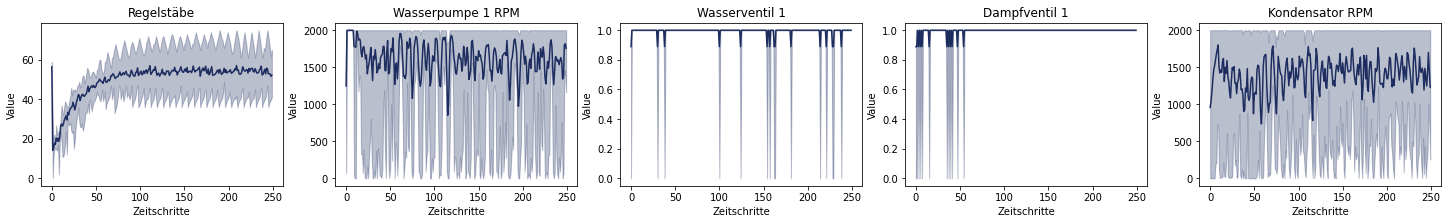

In [15]:
# Create Actions Mean without model 10
path=paths_best_models[0]
actions_prepared_wo_10, obs_prepared_wo_10,list_of_all_actions_taken_wo_10,list_of_all_obs_take_wo_10n=prepare_one_combiniation_actions_and_obs_for_analysis(path,number_of_models=9)
for idx,item in enumerate(actions_prepared_wo_10):
    item=item.applymap(lambda x: int(round((x + 1) * (scaling_factors_scenario_1[idx] / 2))))
    actions_prepared_wo_10[idx]=item.agg(["mean","min","max","std"],axis=1)
    actions_prepared_wo_10[idx]["minus"]=actions_prepared_wo_10[idx]["mean"]-actions_prepared_wo_10[idx]["std"]
    actions_prepared_wo_10[idx]["plus"]=actions_prepared_wo_10[idx]["mean"]+actions_prepared_wo_10[idx]["std"]
fig, ax = plt.subplots(1, 5,constrained_layout=True)
fig.set_figheight(3) 
fig.set_figwidth(20) 
[ax[idx].plot(item["mean"],color=color_mapping["standard"]) for idx, item in enumerate(actions_prepared_wo_10)]
[ax[idx].fill_between([i for i in range(250)],item["min"],item["max"],color=color_mapping["standard"],alpha=0.3) for idx, item in enumerate(actions_prepared_wo_10)]
[ax[idx].set_xlabel("Zeitschritte") for idx in range(5)]
[ax[idx].set_ylabel("Value") for idx in range(5)]
[ax[idx].set_title(action_dimensions_german[idx]) for idx in range(5)]

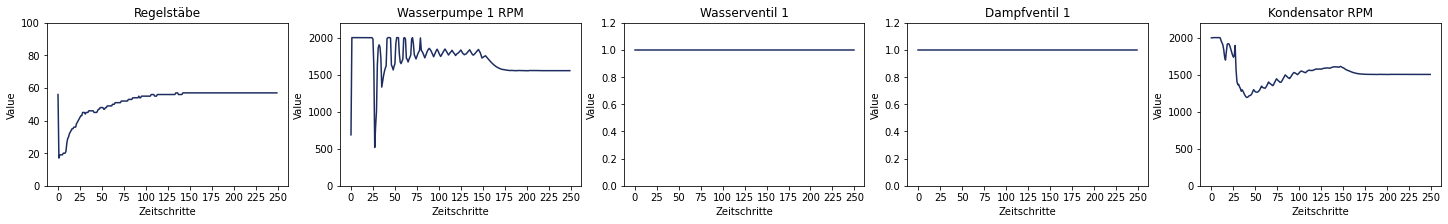

In [12]:
# Action: Modell 2  Combi 1
from src.main.rl.evaluation.eval import plot_actions_taken
scenario="scenario1"
y_axis_scale=[[0, 100], [0, 2200], [0, 1.2], [0, 1.2], [0, 2200]]
fig=plot_actions_taken(list_of_all_actions_taken[2], scenario,y_axis_scale)
#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_actions_plots_scen1_wo_smoothest.png",
#    format="png",
#    dpi=300,
#)

combination 0


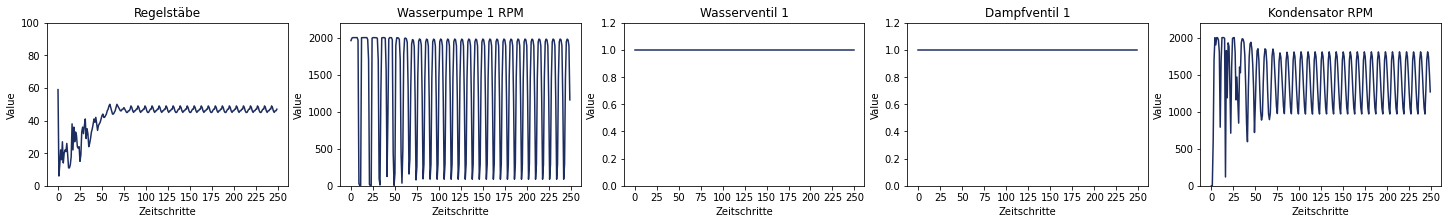

combination 1


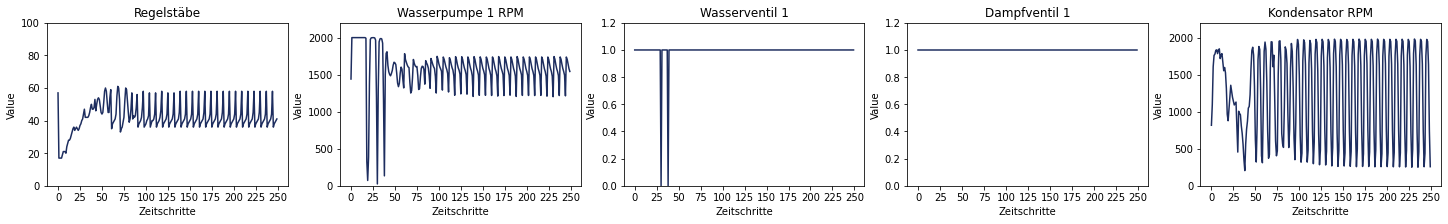

combination 2


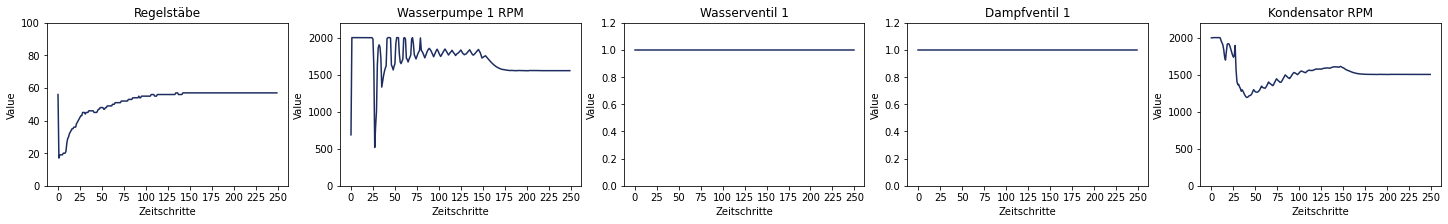

combination 3


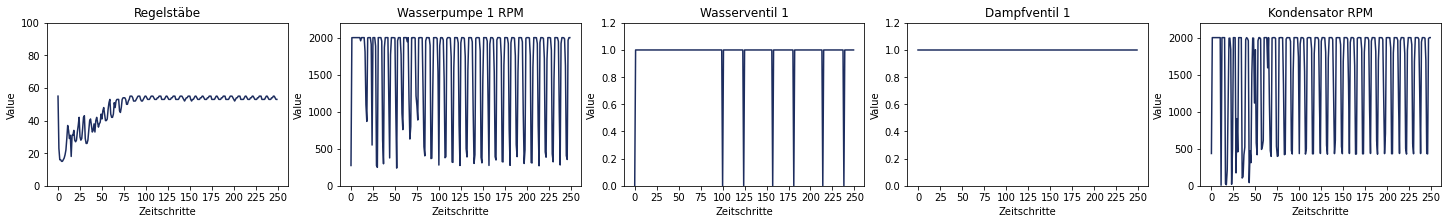

combination 4


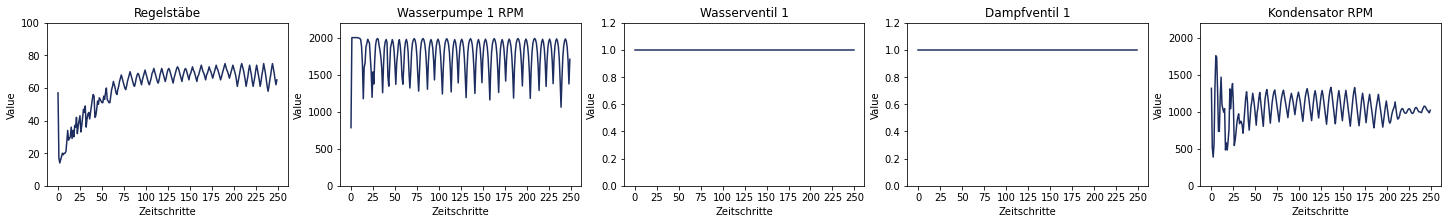

combination 5


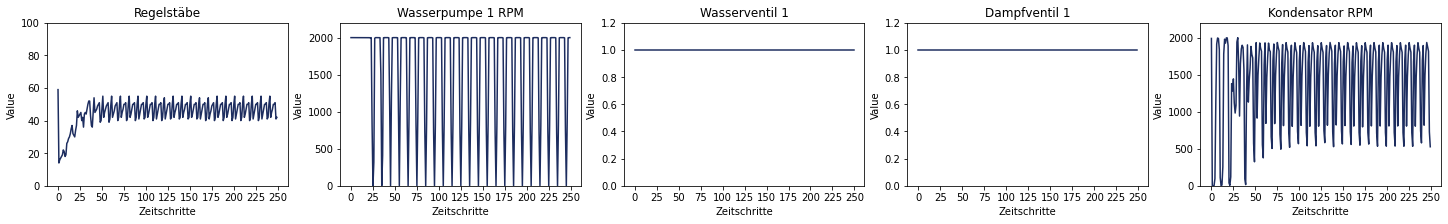

combination 6


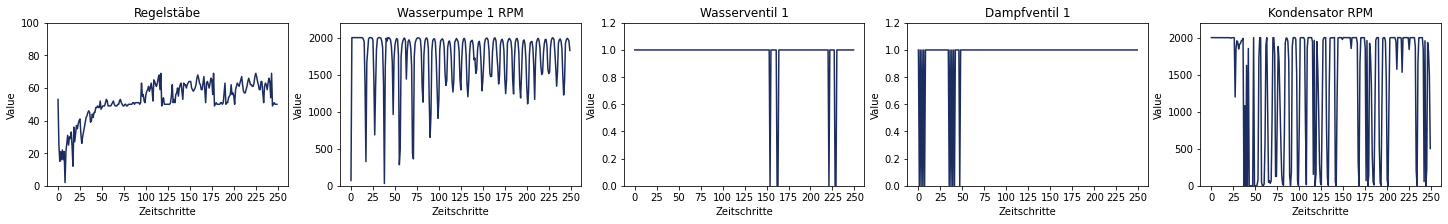

combination 7


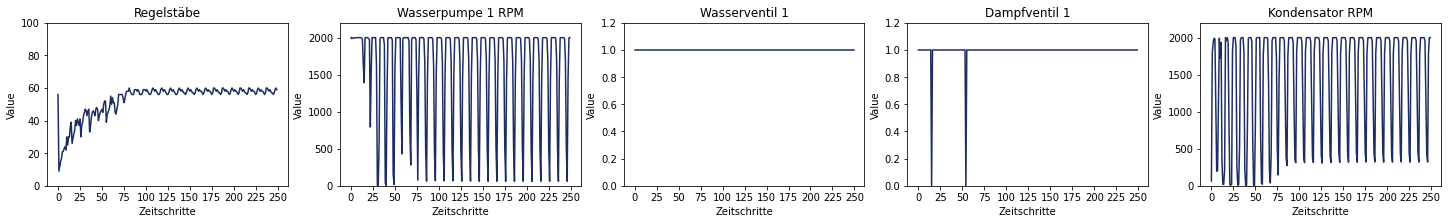

combination 8


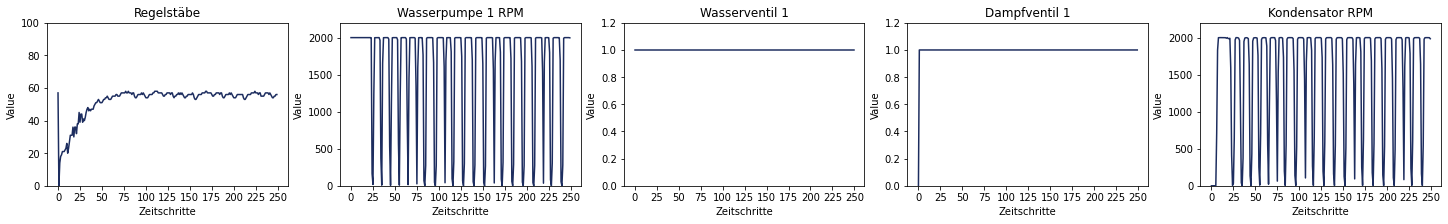

combination 9


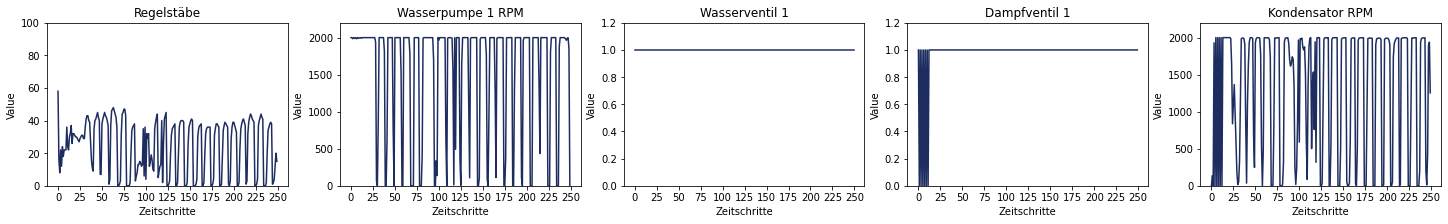

In [13]:
# Actions print all combinations from scen 1
from src.main.rl.evaluation.eval import plot_actions_taken
y_axis_scale=[[0, 100], [0, 2200], [0, 1.2], [0, 1.2], [0, 2200]]
for idx,actions_taken in enumerate(list_of_all_actions_taken):
    print(f"combination {idx}")
    plot_actions_taken(actions_taken, scenario,y_axis_scale)


In [16]:
#Observation prep 
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from src.main.rl.utils.constants import (
    scaling_factors_scenario_1,
    scaling_factors_scenario2,
    action_dimensions_german,
    obs_dimensions_german,
    obs_scaling_factors,
    obs_dimensions,
    scaling_factors_scenario3,
)
obs_space_size = 6

current_obs_scaling_factors = obs_scaling_factors[obs_space_size]

agg_result_list_obs=[pd.DataFrame() for _ in range(6)]
for idx,item in enumerate(obs_prepared):
    item=item.fillna(0)
    item=item.applymap(lambda x: int(round((x + 1) * (current_obs_scaling_factors[idx] / 2))))
    agg_result_list_obs[idx]=item.agg(["mean","min","max","std"],axis=1)
    agg_result_list_obs[idx]["minus"]=agg_result_list_obs[idx]["mean"]-agg_result_list_obs[idx]["std"]
    agg_result_list_obs[idx]["plus"]=agg_result_list_obs[idx]["mean"]+agg_result_list_obs[idx]["std"]


[(0.0, 1000.0),
 (0.0, 4000.0),
 (0.0, 550.0),
 (0.0, 8000.0),
 (0.0, 180.0),
 (0.0, 32.0)]

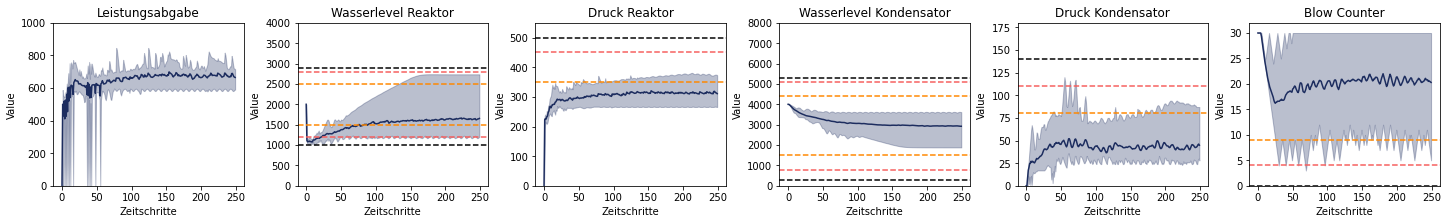

In [17]:

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
obs_space_size = 6
current_obs_scaling_factors = obs_scaling_factors[obs_space_size]
color_mapping = {
    "standard": "#1D2D5F",
    "red":"#F65E5D",
    "orange": "#FF8800",
}

#Plot
y_axis_scale=[[0,1000],[0,4000],[0,550],[0,8000],[0,180],[0,32]]
red_critical_line_1=[-10,2800,450,5100,110,4]
red_critical_line_2=[-10,1200,-10,800,-10,-10]
orange_critical_line_1=[-10,2500,350,4400,80,9]
orange_critical_line_2=[-10,1500,-10,1500,-10,-10]
dead_line_1=[-10,2900, 500,5300,140,0]
dead_line_2=[-10,1000,-10,300,-10,-10]

fig, ax = plt.subplots(1, int(obs_space_size),constrained_layout=True)
fig.set_figheight(3) 
fig.set_figwidth(20) 
[ax[idx].plot(item["mean"],color=color_mapping["standard"]) for idx, item in enumerate(agg_result_list_obs)]
[ax[idx].fill_between([i for i in range(250)],item["min"],item["max"],color=color_mapping["standard"],alpha=0.3) for idx, item in enumerate(agg_result_list_obs)]
[ax[idx].set_xlabel("Zeitschritte") for idx in range(obs_space_size)]
[ax[idx].set_ylabel("Value") for idx in range(obs_space_size)]
[ax[idx].set_title(obs_dimensions_german[obs_space_size][idx]) for idx in range(obs_space_size)]
[ax[idx].axhline(red_critical_line_1[idx],color=color_mapping["red"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(red_critical_line_2[idx],color=color_mapping["red"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(orange_critical_line_1[idx],color=color_mapping["orange"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(orange_critical_line_2[idx],color=color_mapping["orange"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(dead_line_1[idx],color="black",ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(dead_line_2[idx],color="black",ls='--') for idx in range(obs_space_size)]
[ax[idx].set_ylim(y_axis_scale[idx]) for idx in range(obs_space_size)]

#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_obs_plot_with_min_max_scen1_wo_all_models.png",
#    format="png",
#    dpi=300,
#)
#plt.show()

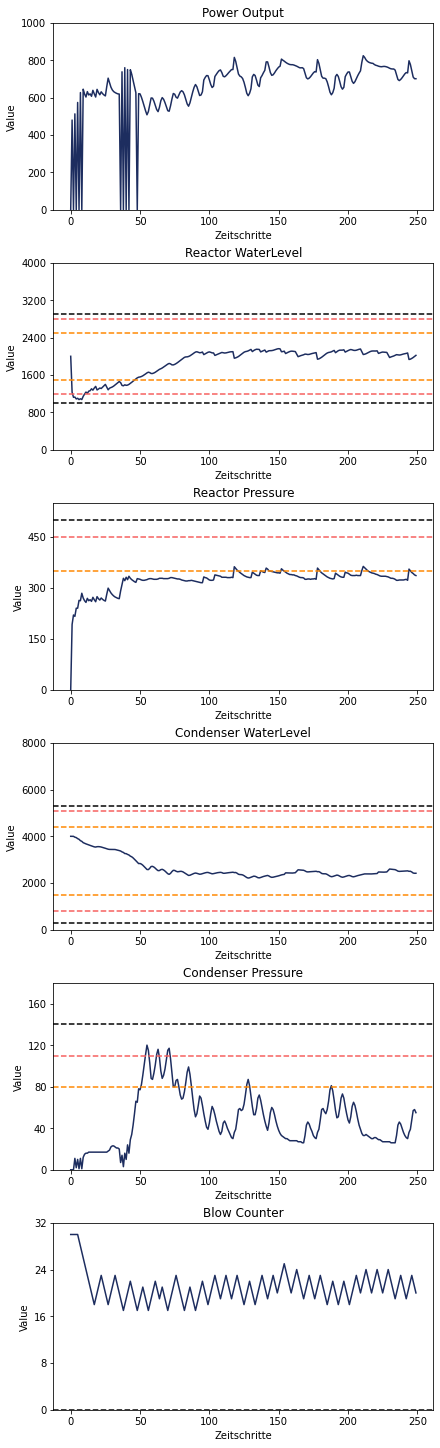

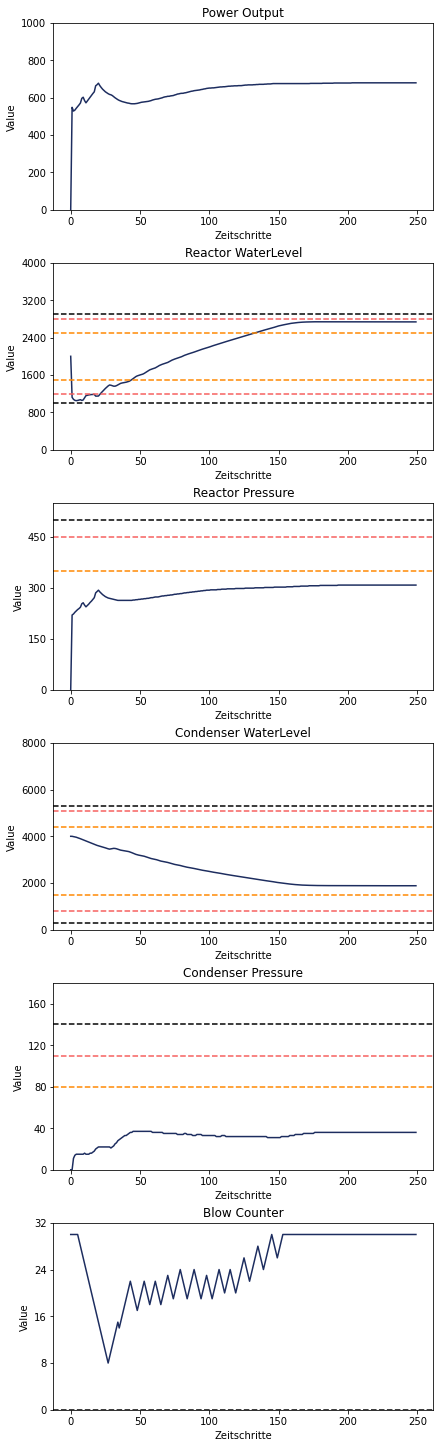

In [20]:
# Obs: Print specific models
from src.main.rl.evaluation.eval import plot_observations
y_axis_scale=[[0, 1000], [0, 4000], [0, 550], [0, 8000], [0, 180],[0, 32]]
fig=plot_observations(list_of_all_obs_taken[6],y_axis_scale)
#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_actions_plots_scen1_wo_smoothest.png",
#    format="png",
#    dpi=300,
#)
from src.main.rl.evaluation.eval import plot_observations
y_axis_scale=[[0, 1000], [0, 4000], [0, 550], [0, 8000], [0, 180],[0, 32]]
fig=plot_observations(list_of_all_obs_taken[2],y_axis_scale)
#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_obs_scen1_wo_combi8_increasing_wl_1000_ep_failure.png",
#    format="png",
#    dpi=300,
#)

combination 0


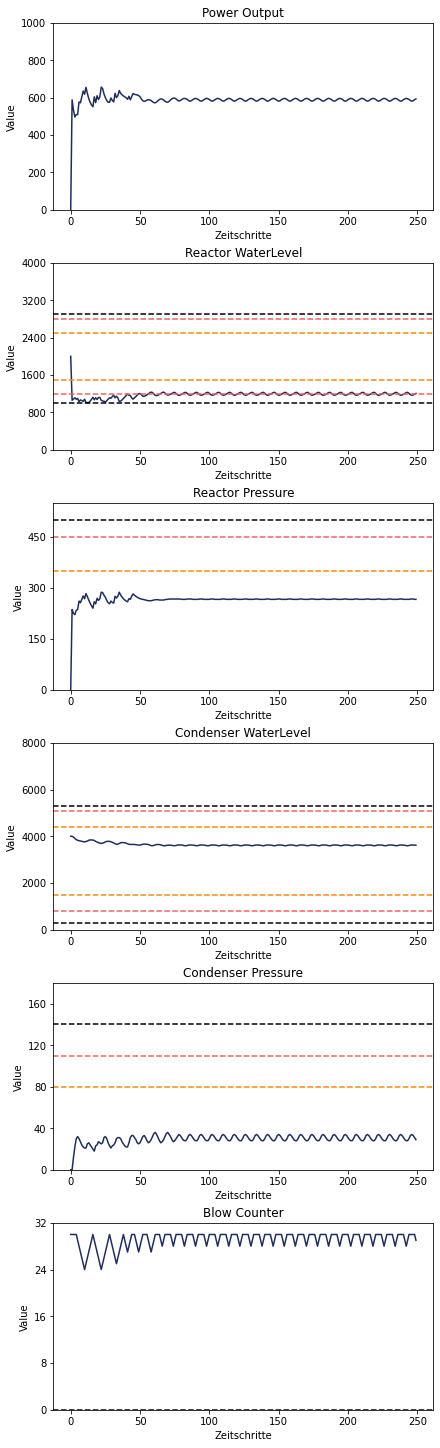

combination 1


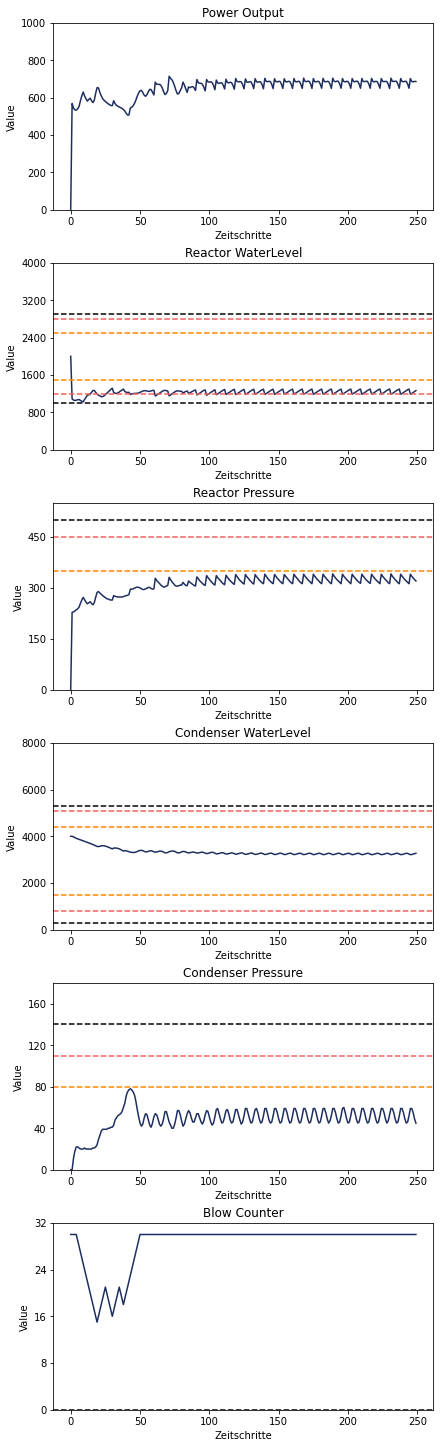

combination 2


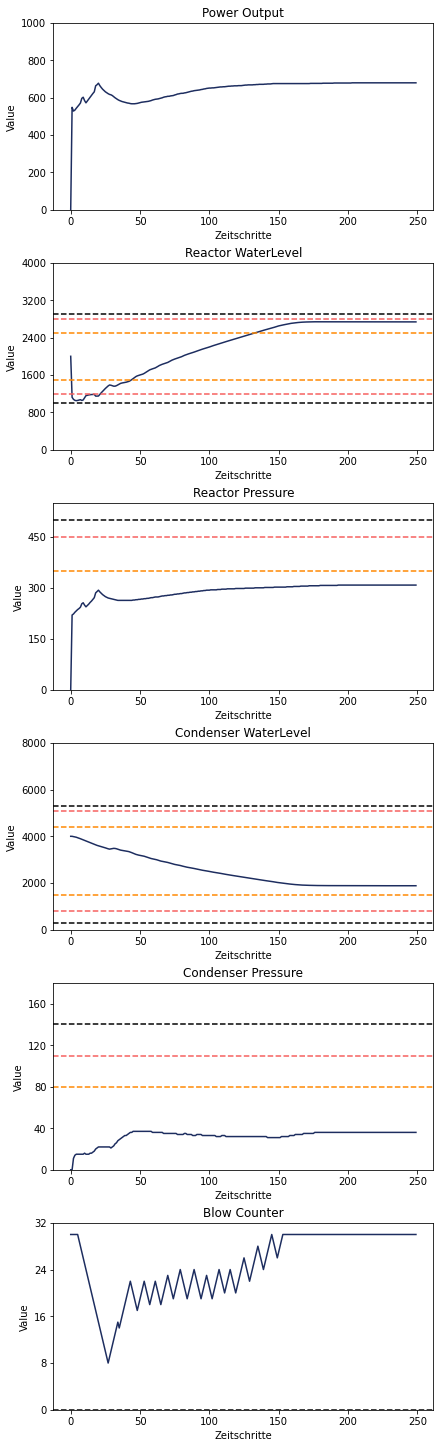

combination 3


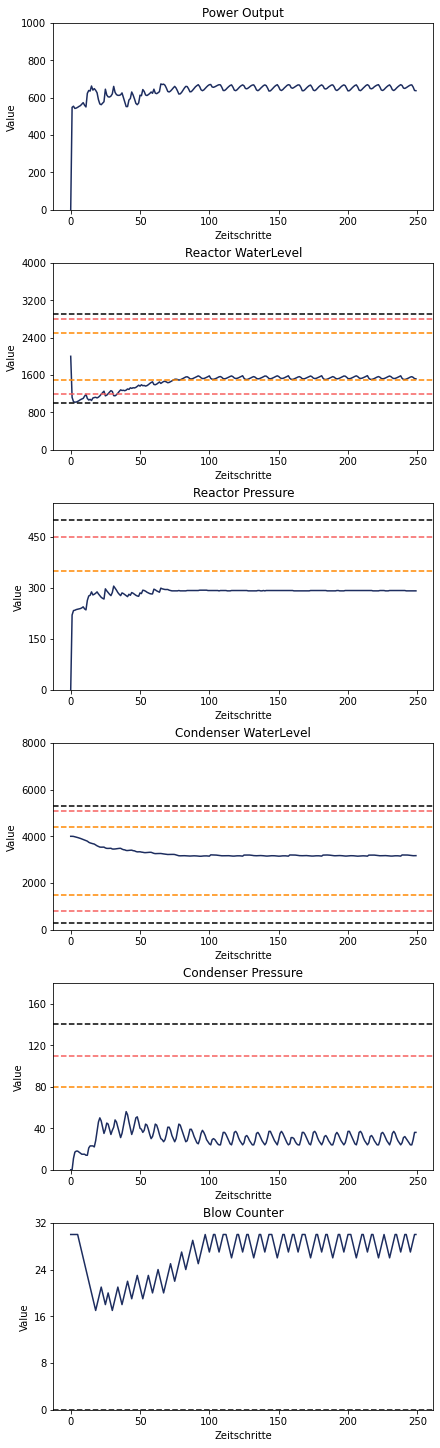

combination 4


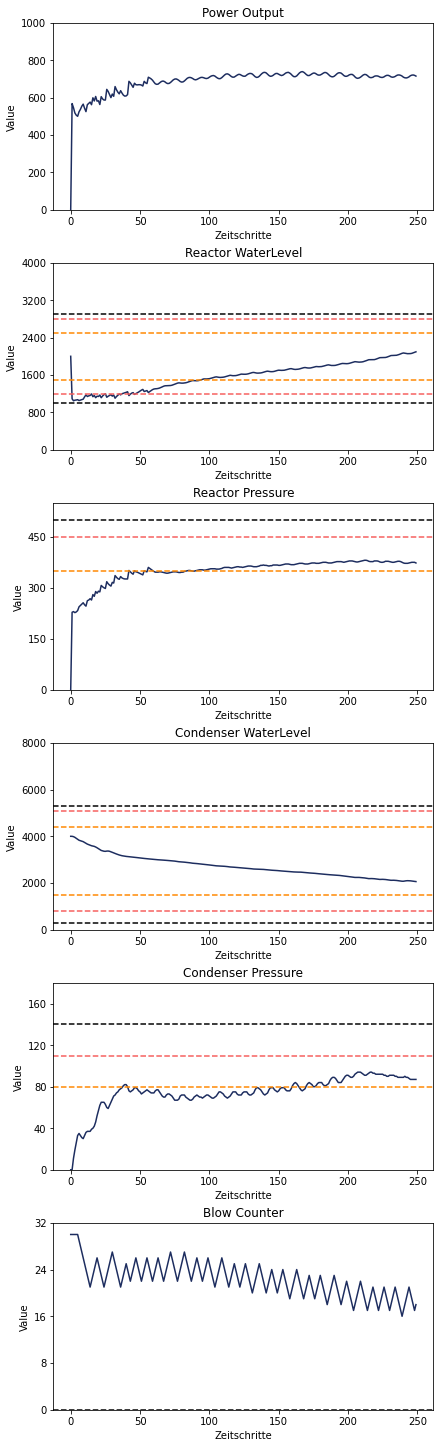

combination 5


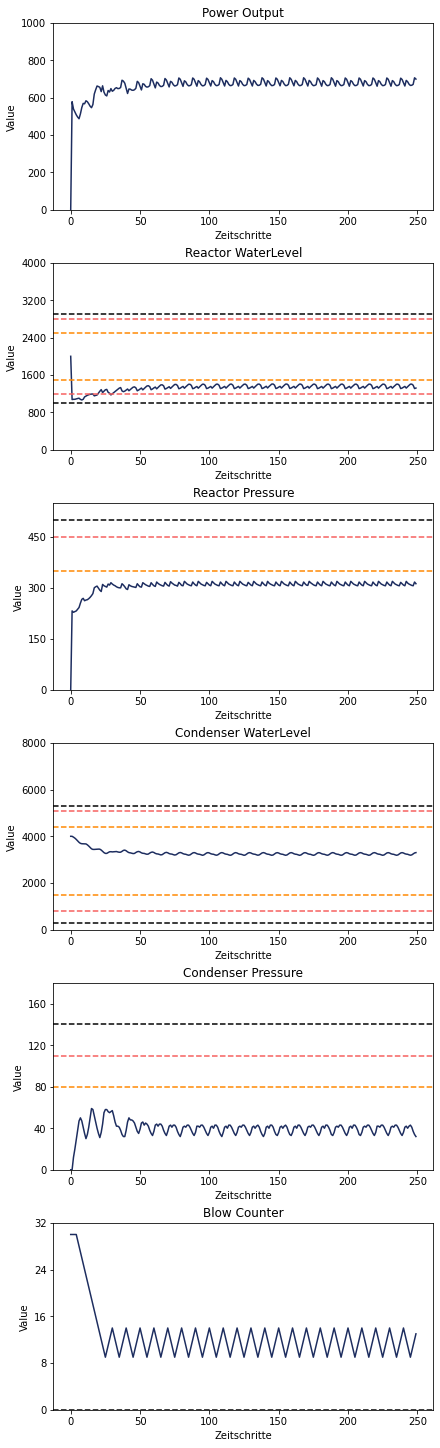

combination 6


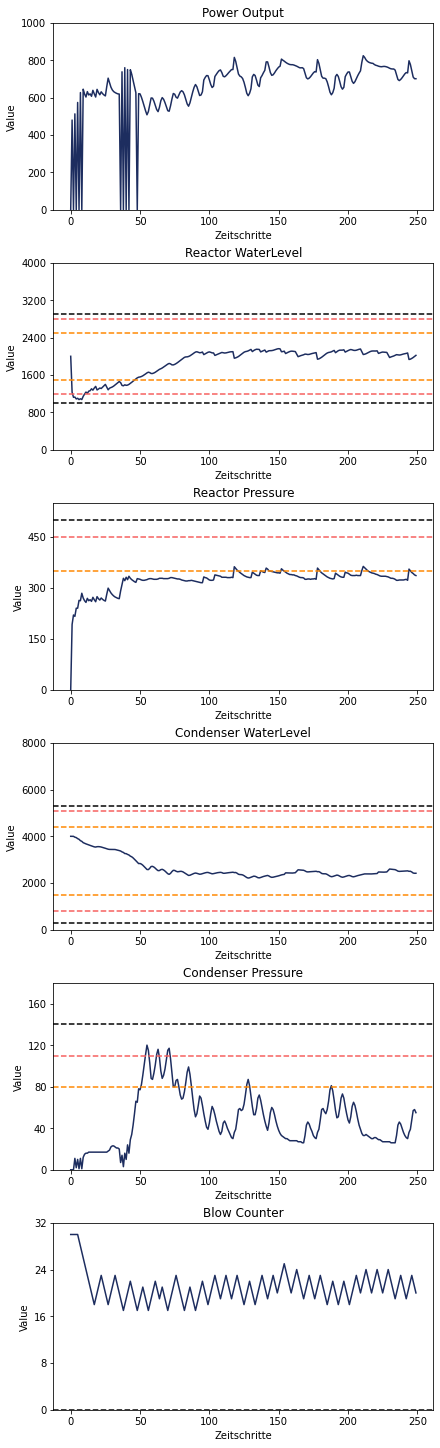

combination 7


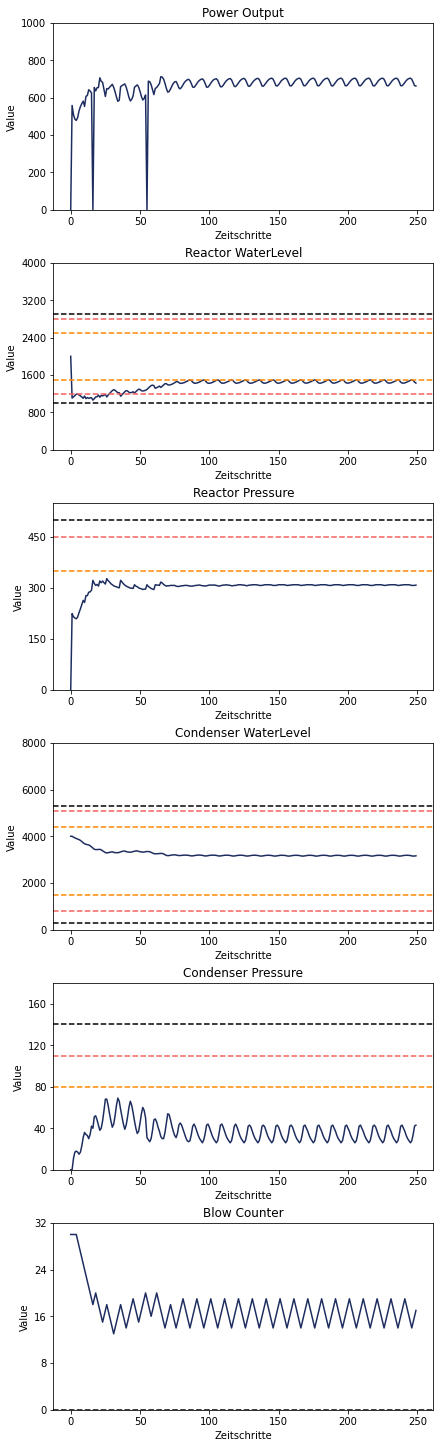

combination 8


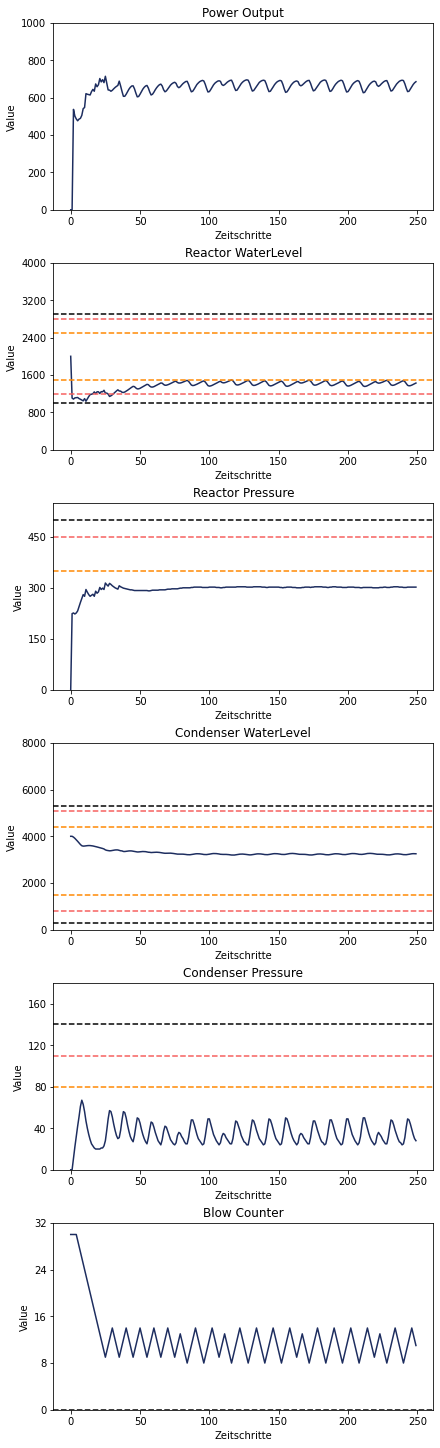

combination 9


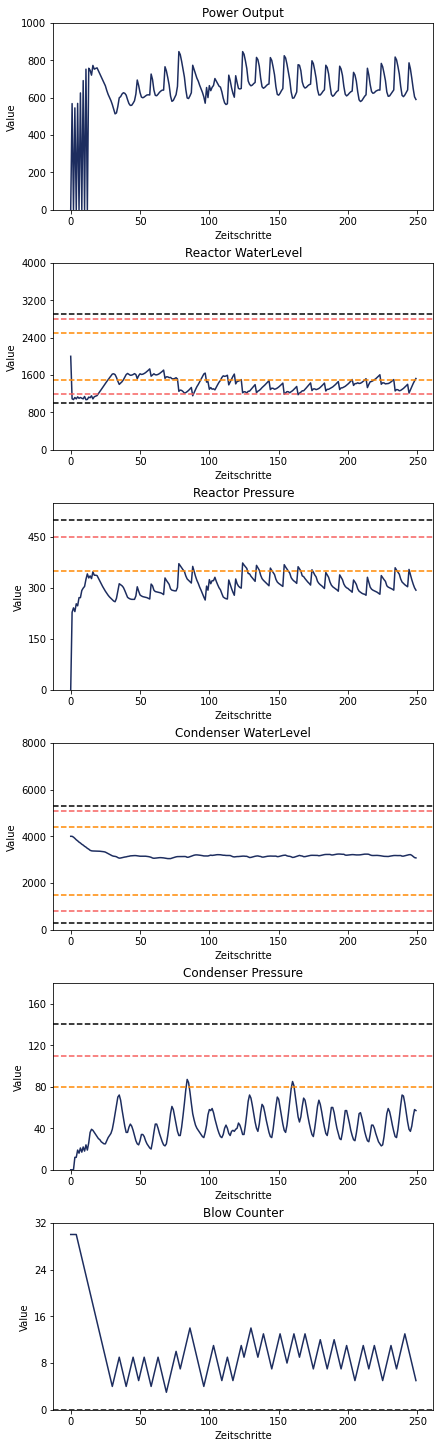

In [18]:
# Obs print all combinations from scen 1
from src.main.rl.evaluation.eval import plot_observations,plot_actions_taken

y_axis_scale=[[0, 1000], [0, 4000], [0, 550], [0, 8000], [0, 180],[0, 32]]
for idx,obs_taken in enumerate(list_of_all_obs_taken):
    print(f"combination {idx}")
    plot_observations(obs_taken,y_axis_scale)


In [22]:
#Obs prep - This cell and the next can only be run if the other cell for calculating the agg statistics 
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from src.main.rl.utils.constants import (
    scaling_factors_scenario_1,
    scaling_factors_scenario2,
    action_dimensions_german,
    obs_dimensions_german,
    obs_scaling_factors,
    obs_dimensions,
    scaling_factors_scenario3,
)
obs_space_size = 6

current_obs_scaling_factors = obs_scaling_factors[obs_space_size]
no_agg_result_list_obs=[pd.DataFrame() for _ in range(6)]
for idx,item in enumerate(obs_prepared):
    no_agg_result_list_obs[idx]=item.applymap(lambda x: int(round((x + 1) * (current_obs_scaling_factors[idx] / 2))))

[(0.0, 1000.0),
 (0.0, 4000.0),
 (0.0, 550.0),
 (0.0, 8000.0),
 (0.0, 180.0),
 (0.0, 32.0)]

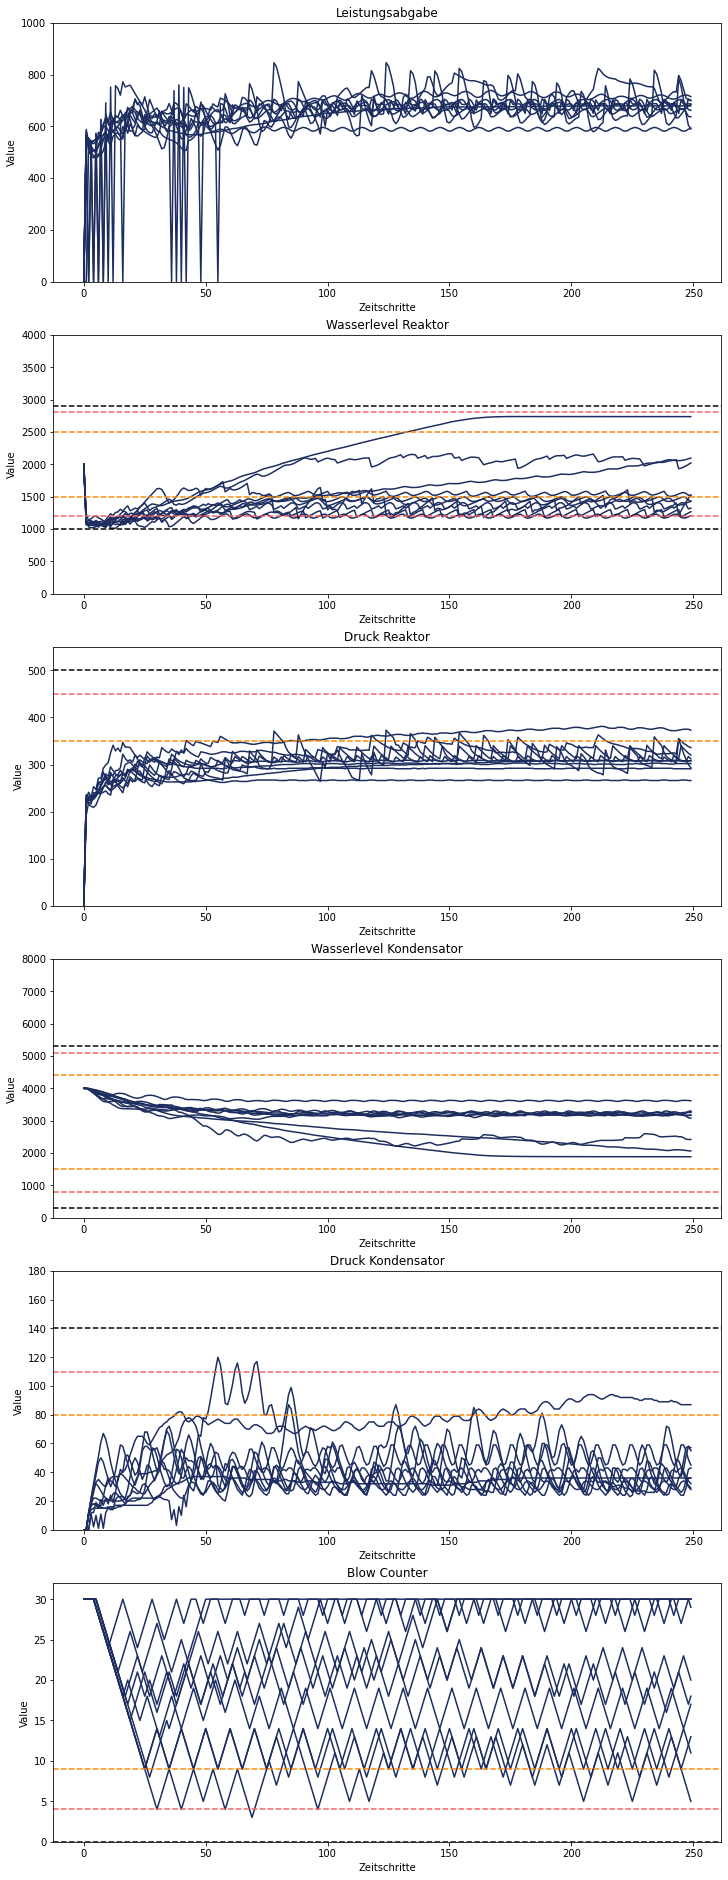

In [23]:
#Obs
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from src.main.rl.utils.constants import (
    scaling_factors_scenario_1,
    scaling_factors_scenario2,
    action_dimensions_german,
    obs_dimensions_german,
    obs_scaling_factors,
    obs_dimensions,
    scaling_factors_scenario3,
)
color_mapping = {
    "standard": "#1D2D5F",
    "red":"#F65E5D",
    "orange": "#FF8800",
}
#Plot
y_axis_scale=[[0,1000],[0,4000],[0,550],[0,8000],[0,180],[0,32]]
red_critical_line_1=[-10,2800,450,5100,110,4]
red_critical_line_2=[-10,1200,-10,800,-10,-10]
orange_critical_line_1=[-10,2500,350,4400,80,9]
orange_critical_line_2=[-10,1500,-10,1500,-10,-10]
dead_line_1=[-10,2900, 500,5300,140,0]
dead_line_2=[-10,1000,-10,300,-10,-10]
obs_space_size = 6
fig, ax = plt.subplots(int(obs_space_size),1 ,constrained_layout=True)
fig.set_figheight(26) 
fig.set_figwidth(10)
for number in range(0,10):
    [ax[idx].plot(item.iloc[:,number],color=color_mapping["standard"]) for idx, item in enumerate(no_agg_result_list_obs)]
    
    #[ax[idx].plot(item[column],color=color_mapping["standard"]) for idx, item in enumerate(no_agg_result_list_obs)]

[ax[idx].set_xlabel("Zeitschritte") for idx in range(obs_space_size)]
[ax[idx].set_ylabel("Value") for idx in range(obs_space_size)]
[ax[idx].set_title(obs_dimensions_german[obs_space_size][idx]) for idx in range(obs_space_size)]
[ax[idx].axhline(red_critical_line_1[idx],color=color_mapping["red"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(red_critical_line_2[idx],color=color_mapping["red"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(orange_critical_line_1[idx],color=color_mapping["orange"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(orange_critical_line_2[idx],color=color_mapping["orange"],ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(dead_line_1[idx],color="black",ls='--') for idx in range(obs_space_size)]
[ax[idx].axhline(dead_line_2[idx],color="black",ls='--') for idx in range(obs_space_size)]
[ax[idx].set_ylim(y_axis_scale[idx]) for idx in range(obs_space_size)]

#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_obs_plot_with_min_max_scen1_wo_all_models.png",
#    format="png",
#    dpi=300,
#)
#plt.show()

In [27]:
# SOP Analysis
from src.main.rl.evaluation.eval import evaluate_sop

cum_reward_sop, criticality_score_sop, total_timesteps_sop, actions_taken_sop, obs_taken_sop, info_sop = evaluate_sop()


x
Criticality Score1: 241.6088288745206
[184.50047]


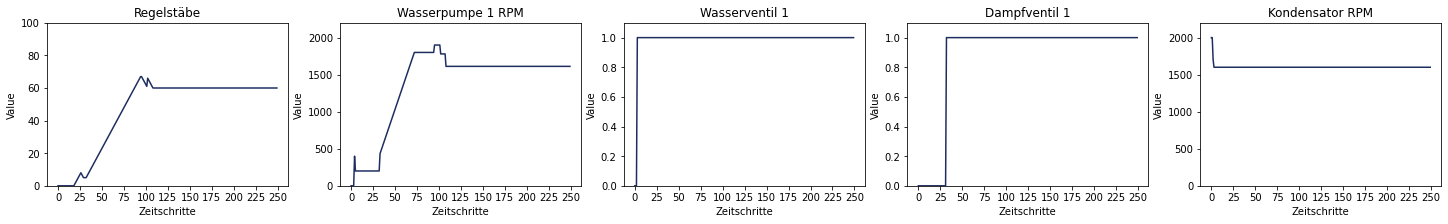

In [28]:
from src.main.rl.evaluation.eval import plot_observations,plot_actions_taken
y_axis_scale_actions=[[0,100],[0,2200],[0,1.1],[0,1.1],[0,2200]]
fig=plot_actions_taken(actions_taken_sop,"scenario1",y_axis_scale_actions)
#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_action_sop.png",
#    format="png",
#    dpi=300,
#)

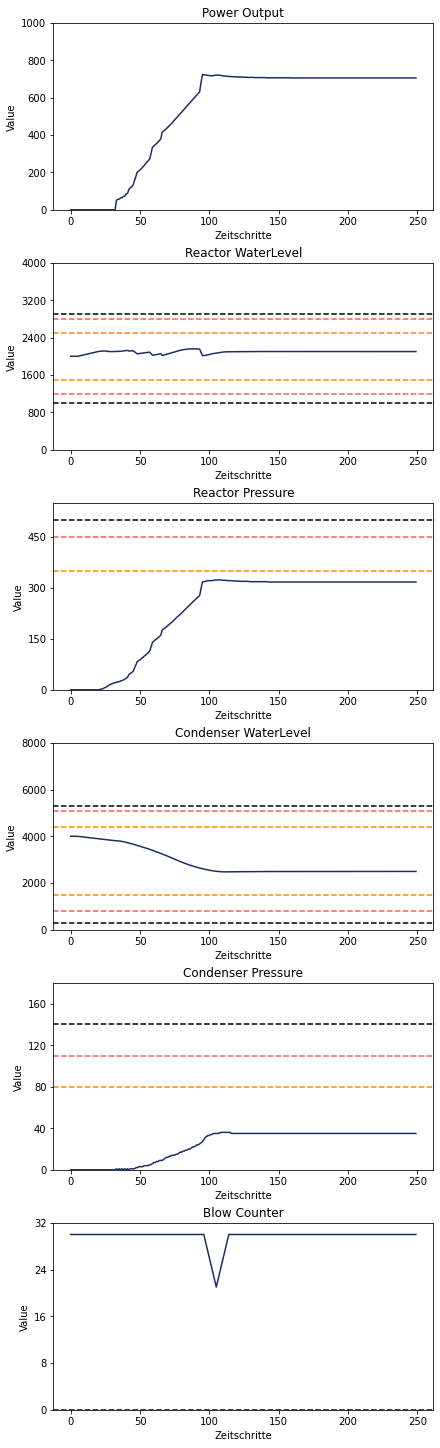

In [29]:
from src.main.rl.evaluation.eval import plot_observations,plot_actions_taken

y_axis_scale_obs=[[0, 1000], [0, 4000], [0, 550], [0, 8000], [0, 180],[0, 32]]
fig=plot_observations(obs_taken_sop,y_axis_scale_obs)
#fig.savefig(
#    f"src/main/rl/evaluation/plot_results/phase3_obs_sop.png",
#    format="png",
#    dpi=300,
#)

In [31]:
# 1000 length
cols=[item for item in df_statistics_per_combination.columns if "1000" in item]
df_statistics_per_combination[cols].round(2)


,,episode_length_1000_mean,episode_length_1000_max,episode_length_1000_min,episode_length_1000_std,episode_length_1000_iqr,episode_length_1000_criticality_mean,episode_length_1000_criticality_max,episode_length_1000_criticality_min,episode_length_1000_criticality_std,episode_length_1000_criticality_iqr,episode_length_1000_timesteps_mean,episode_length_1000_timesteps_max,episode_length_1000_timesteps_min,episode_length_1000_timesteps_std,episode_length_1000_timesteps_iqr
index,combination,,,,,,,,,,,,,,,
0,../models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_None_RewardOption2Wrapper_TD3_training_04_06,815.70,968.34,351.00,245.34,104.64,679.86,953.54,260.29,225.38,83.35,875.1,1000,367,263.34,0.0
1,../models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_SAC_training_04_06,969.31,987.06,935.07,17.40,9.41,773.80,928.75,725.51,59.56,45.26,1000.0,1000,1000,0.00,0.0
2,../models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06,815.12,937.83,661.70,76.70,90.47,874.73,949.82,745.76,66.35,68.89,1000.0,1000,1000,0.00,0.0
3,../models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_PPO_training_04_06,922.86,944.95,881.35,25.64,37.73,828.02,964.35,688.08,99.74,143.36,1000.0,1000,1000,0.00,0.0
4,../models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06,913.10,968.26,843.89,41.59,66.05,911.18,956.08,782.02,52.41,47.91,1000.0,1000,1000,0.00,0.0
5,../models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_A2C_training_04_06,489.16,954.25,227.21,301.01,476.20,426.99,936.94,208.66,266.74,409.80,518.9,1000,247,316.42,505.5


In [33]:
# EXP1: Criticality Score per combination
print(df_statistics_per_combination[["episode_length_1000_mean"]].round(2))


print(df_statistics_per_combination[cols].round(2).droplevel(1)[["episode_length_1000_mean","episode_length_1000_max","episode_length_1000_std","episode_length_1000_iqr","episode_length_1000_timesteps_mean"]].transpose().to_latex())

                                                                                                                                                                     episode_length_1000_mean
index combination                                                                                                                                                                            
0     ../models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_None_RewardOption2Wrapper_TD3_training_04_06                                    815.70
1     ../models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_SAC_training_04_06                    969.31
2     ../models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06                                    815.12
3     ../models/scenario2/training_04_06/scenario2

C:\Users\Niklas\AppData\Local\Temp\ipykernel_2112\1061444987.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_statistics_per_combination[cols].round(2).droplevel(1)[["episode_length_1000_mean","episode_length_1000_max","episode_length_1000_std","episode_length_1000_iqr","episode_length_1000_timesteps_mean"]].transpose().to_latex())


In [10]:
# 1000 length statistics over the whole df
cols=[item for item in df_total.columns if "1000" in item]
df_total[cols].round(2)


,episode_length_1000_condensator_pump_blown,episode_length_1000_water_pump_blown,episode_length_1000,episode_length_1000_criticality,episode_length_1000_timesteps
index,,,,,
mean,0.033333,0.0,820.88,749.10,899.00
max,True,False,987.06,964.35,1000.00
min,False,False,227.21,208.66,247.00
std,0.18102,0.0,223.40,220.08,239.48
iqr,NaN,NaN,122.24,185.67,0.00


In [7]:
df[["episode_length_1000_condensator_pump_blown","episode_length_1000_water_pump_blown"]].sum()

episode_length_1000_condensator_pump_blown    2
episode_length_1000_water_pump_blown          0
dtype: int64

In [14]:
cols=[item for item in df_statistics_per_combination.columns if "criti" in item]
df_statistics_per_combination[cols].round(2)

,,criticality_score_mean,criticality_score_max,criticality_score_min,criticality_score_std,criticality_score_iqr,result_wo_npp_automation_criticality_mean,result_wo_npp_automation_criticality_max,result_wo_npp_automation_criticality_min,result_wo_npp_automation_criticality_std,result_wo_npp_automation_criticality_iqr,...,create_starting_state_option3a_criticality_mean,create_starting_state_option3a_criticality_max,create_starting_state_option3a_criticality_min,create_starting_state_option3a_criticality_std,create_starting_state_option3a_criticality_iqr,create_starting_state_option3b_criticality_mean,create_starting_state_option3b_criticality_max,create_starting_state_option3b_criticality_min,create_starting_state_option3b_criticality_std,create_starting_state_option3b_criticality_iqr
index,combination,,,,,,,,,,,,,,,,,,,,,
0,src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_None_RewardOption2Wrapper_TD3_training_04_06,192.26,225.07,174.97,14.51,13.91,NaN,NaN,NaN,NaN,NaN,...,158.91,206.47,0.45,74.36,28.36,114.51,210.87,0.42,81.96,131.37
1,src/main/rl/models/scenario1/training_04_06/scenario1_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_SAC_training_04_06,190.93,221.27,181.04,11.88,8.54,198.63,222.15,175.68,14.04,15.74,...,206.41,222.74,186.18,10.94,9.75,201.61,208.53,189.23,5.69,6.45
2,src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06,220.51,229.91,196.50,9.77,8.25,NaN,NaN,NaN,NaN,NaN,...,208.60,216.51,190.78,7.05,5.15,194.47,205.27,183.24,6.19,6.27
3,src/main/rl/models/scenario2/training_04_06/scenario2_ActionSpaceOption3Wrapper_ObservationOption4Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_PPO_training_04_06,214.11,237.44,187.31,19.21,31.53,144.32,221.78,31.15,83.13,152.79,...,193.06,214.13,147.99,21.47,18.23,185.40,202.41,167.65,10.34,14.32
4,src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_None_RewardOption2Wrapper_PPO_training_04_06,226.44,236.23,201.51,10.13,8.38,NaN,NaN,NaN,NaN,NaN,...,215.63,223.47,201.78,6.61,8.37,194.93,213.13,107.23,31.27,9.61
5,src/main/rl/models/scenario3/training_04_06/scenario3_ActionSpaceOption3Wrapper_ObservationOption5Wrapper_NPPAutomationWrapper_RewardOption2Wrapper_A2C_training_04_06,206.42,220.17,172.82,17.10,10.86,3.84,3.84,3.83,0.01,0.01,...,191.12,210.09,148.96,19.51,24.71,168.59,206.38,136.42,23.88,31.76


In [2]:
############## Start: Exp Noise ###################




[{'Reactor_WaterLevel': 1483.5291388017995,
  'Reactor_Pressure': 301.89482359072235,
  'Condenser_WaterLevel': 3210.692992135623,
  'Condenser_Pressure': 24.549643674920322,
  'Blow_Counter': 8,
  'Condensator_Pump Blown': True,
  'Water_Pump Blown': False,
  'episode': {'r': 360.837143, 'l': 384, 't': 0.199998},
  'terminal_observation': array([ 0.7325    , -0.25823543,  0.09779936, -0.19732675, -0.72722618,
         -0.46666667])}]